In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"Athanasika RK","key":"3d6dd32a87658d98b64a0cc1b4e8dddb"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
import kaggle
get_ipython().system('kaggle datasets download -d odins0n/ucf-crime-dataset')

OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

In [ ]:
!unzip 'ucf-crime-dataset'

unzip:  cannot find or open ucf-crime-dataset, ucf-crime-dataset.zip or ucf-crime-dataset.ZIP.


In [ ]:
train_dir = "/content/Train"
test_dir = "/content/Test"

## **IMAGE PROCESSING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D,Flatten
from tensorflow.keras.models import Sequential

In [ ]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = "/content/Train"
test_dir = "/content/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003

In [ ]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [ ]:
crimes={}
train=test=0
for clss in crime_types:
  num=len(os.listdir(os.path.join(train_dir,clss)))
  train+=num
  test+=len(os.listdir(os.path.join(test_dir,clss)))

  crimes[clss]=num

Text(0.5, 1.0, 'Train and Test images')

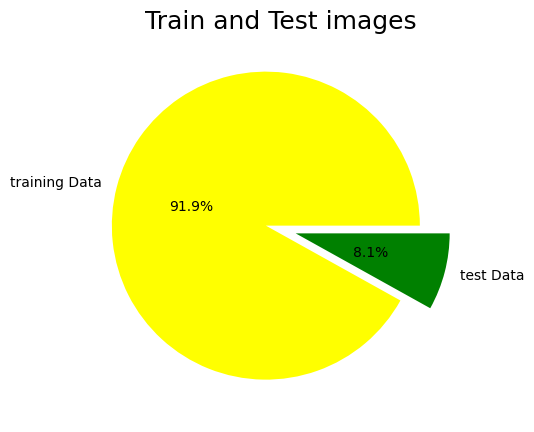

In [ ]:
plt.figure(figsize=(8,5))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=('training Data', "test Data"), pctdistance=0.5,colors=['yellow','green'])
plt.title("Train and Test images", fontsize=18)

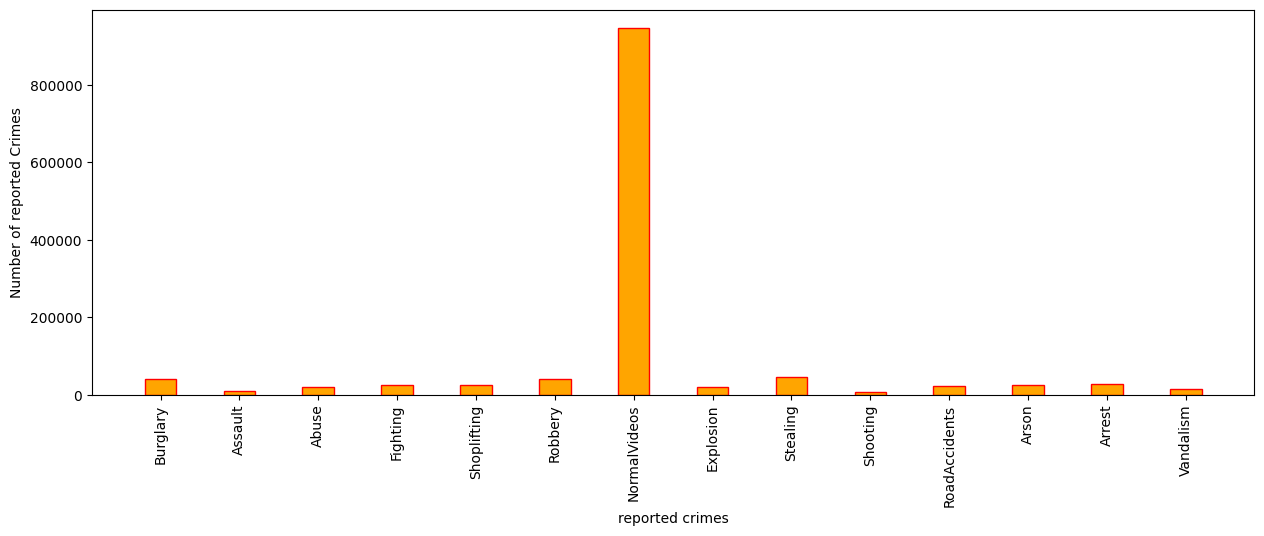

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4,align="center",edgecolor=['red'],color=['orange'])
plt.xticks(rotation=90)

plt.xlabel("reported crimes")
plt.ylabel("Number of reported Crimes")
plt.show()

In [ ]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=128,
    image_size=(64,64),
    shuffle=True,
    seed=12,
    validation_split=0.2,
    subset="training",
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [ ]:
val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=128,
    image_size=(64,64),
    shuffle=True,
    seed=12,
    validation_split=0.2,
    subset="validation",
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [ ]:
test_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=128,
    image_size=(64,64),
    shuffle=False,
    seed=12,
    validation_split=0.2,
    subset="both"
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Using 253269 files for validation.


## **MODEL BUILDING**

In [ ]:
def transfer_learning():
  base_model=DenseNet121(include_top=False,input_shape=(64,64,3),weights="imagenet")

  thr=149
  for layers in base_model.layers[:thr]:
    layers.trainable=False

  for layers in base_model.layers[thr:]:
    layers.trainable=False

  return base_model

In [ ]:
def create_model():
  model=Sequential()

  base_model=transfer_learning()
  model.add(base_model)

  model.add(GlobalAveragePooling2D())

  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1024, activation="relu"))

  model.add(Dense(n,activation="softmax"))

  model.summary()

  return model

In [ ]:
model=create_model()

model.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

29084464/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
 dense_2 (Dense)             (None, 14)                14

In [ ]:
history = model.fit(x = train_set, validation_data=val_set,epochs = 5)

Epoch 1/5
7915/7915 [==============================] - 1274s 161ms/step - loss: 0.1001 - accuracy: 0.9748 - val_loss: 0.0441 - val_accuracy: 0.9880
Epoch 2/5
1278/7915 [===>..........................] - ETA: 14:10 - loss: 0.1003 - accuracy: 0.9755

In [ ]:
model.save('crime.h5')

In [ ]:
from tensorflow.keras.models import load_model
model.load_weights('crime.h5')

NameError: ignored

In [ ]:
y_true = np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true,np.argmax(y.numpy(), axis=-1)])

ValueError: ignored

In [ ]:
y_pred=model.predict(test_set)

9894/9894 [==============================] - 634s 64ms/step


In [ ]:
y_pred

array([[9.99997854e-01, 5.04572455e-08, 1.70624261e-08, ...,
        3.35451111e-11, 1.03895275e-08, 2.03701875e-10],
       [9.99998212e-01, 4.15426271e-08, 1.10083738e-08, ...,
        8.75682946e-12, 7.06788983e-09, 8.06400363e-11],
       [9.99998093e-01, 3.61791521e-08, 5.29661381e-09, ...,
        3.14278920e-12, 5.41961409e-09, 7.58381483e-11],
       ...,
       [4.47837338e-02, 4.02143002e-02, 1.04518190e-01, ...,
        9.03793424e-03, 6.79397583e-02, 1.17689244e-01],
       [4.74726893e-02, 5.15998527e-02, 9.39709395e-02, ...,
        1.11197829e-02, 6.13812096e-02, 1.14319257e-01],
       [7.89420400e-03, 5.30080311e-02, 5.82500398e-02, ...,
        3.97119019e-03, 4.67470698e-02, 2.09732383e-01]], dtype=float32)

In [ ]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [ ]:
img = image.load_img('/content/Test/Explosion/Explosion002_x264_3480.png',target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
pred = np.argmax(model.predict(x))
op = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
op[pred]

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/Test/Arrest/Arrest001_x264_660.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # Converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probablity index
 # Creating list
list1=['Abuse',
 'Arrest',
 'Arson',
 'Assault',
 'Burglary',
 'Explosion',
 'Fighting',
 'NormalVideos',
 'RoadAccidents',
 'Robbery',
 'Shooting',
 'Shoplifting',
 'Stealing',
 'Vandalism']
list1[pred]

1/1 [==============================] - 0s 32ms/step


'Arrest'

In [ ]:
img = image.load_img('/content/Test/Shooting/Shooting004_x264_150.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # Converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probablity index
 # Creating list
list1=['Abuse',
 'Arrest',
 'Arson',
 'Assault',
 'Burglary',
 'Explosion',
 'Fighting',
 'NormalVideos',
 'RoadAccidents',
 'Robbery',
 'Shooting',
 'Shoplifting',
 'Stealing',
 'Vandalism']
list1[pred]

1/1 [==============================] - 0s 30ms/step


'Shooting'

In [ ]:
img = image.load_img('/content/Test/NormalVideos/Normal_Videos_003_x264_1510.png',target_size=(64,64)) # Reading image
x = image.img_to_array(img) # Converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) # Predicting the higher probablity index
 # Creating list
list1=['Abuse',
 'Arrest',
 'Arson',
 'Assault',
 'Burglary',
 'Explosion',
 'Fighting',
 'NormalVideos',
 'RoadAccidents',
 'Robbery',
 'Shooting',
 'Shoplifting',
 'Stealing',
 'Vandalism']
list1[pred]

1/1 [==============================] - 0s 33ms/step


'NormalVideos'